# Notebook 04 — Species Distribution Modeling & Probability Map (Final)

**Tujuan:**  
1. Train Random Forest SDM dengan data occurrence + environmental variables.  
2. Impute missing values dan buat pseudo-absence realistis.  
3. Prediksi probabilitas distribusi rumput laut di Jepang.  

# 1️⃣ Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

## 2️⃣ Load Cleaned Dataset (Notebook 03)


In [2]:
df = pd.read_csv("../data/processed/occurrence_cleaned_for_sdm.csv")
print("Shape dataset:", df.shape)

Shape dataset: (8267, 12)


## 3️⃣ Impute Missing Values

- SST & salinity → median  
- Depth → median atau 10 jika masih missing


In [3]:
print(df['sst_mean'].isnull().sum())
print(df['salinity_mean'].isnull().sum())
print(df['depth_m'].isnull().sum()) 

0
0
8148


In [4]:
df['sst_mean'].fillna(df['sst_mean'].median(), inplace=True)
df['salinity_mean'].fillna(df['salinity_mean'].median(), inplace=True)
df['depth_m'].fillna(10, inplace=True)

/var/folders/tr/hsp97wws7616hmchtwqyhv4h0000gn/T/ipykernel_28140/3124270962.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sst_mean'].fillna(df['sst_mean'].median(), inplace=True)
/var/folders/tr/hsp97wws7616hmchtwqyhv4h0000gn/T/ipykernel_28140/3124270962.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

## 4️⃣ Generate Realistic Pseudo-absence

- Coastal area Jepang (lat 30–46, lon 129–146)  
- SST & salinity clipped ke range observasi  
- Depth = 10 m


In [5]:
lat_min, lat_max = 30, 46
lon_min, lon_max = 129, 146
n_absence = len(df)

# Ambil range observasi SST & salinity
sst_min, sst_max = df['sst_mean'].min(), df['sst_mean'].max()
sal_min, sal_max = df['salinity_mean'].min(), df['salinity_mean'].max()

# Random coastal points
lat_abs = np.random.uniform(lat_min, lat_max, n_absence)
lon_abs = np.random.uniform(lon_min, lon_max, n_absence)

# Sample environmental data dari Bio-ORACLE
sst_ds = xr.open_dataset("../data/raw/sst-2010-2020.nc")
sst = sst_ds["thetao_mean"].isel(time=0).sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

sal_ds = xr.open_dataset("../data/raw/salinity-2010-2020.nc")
sal = sal_ds["so_mean"].isel(time=0).sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

def sample_biooracle(da, lat, lon):
    return da.sel(latitude=xr.DataArray(lat, dims="points"),
                  longitude=xr.DataArray(lon, dims="points"),
                  method="nearest").values

sst_abs = sample_biooracle(sst, lat_abs, lon_abs)
sal_abs = sample_biooracle(sal, lat_abs, lon_abs)

# Clip ke range observasi
sst_abs = np.clip(sst_abs, sst_min, sst_max)
sal_abs = np.clip(sal_abs, sal_min, sal_max)
depth_abs = np.full(n_absence, 10)

df_absence = pd.DataFrame({
    "decimalLatitude": lat_abs,
    "decimalLongitude": lon_abs,
    "sst_mean": sst_abs,
    "salinity_mean": sal_abs,
    "depth_m": depth_abs,
    "presence": 0
})

# Dataset final untuk modeling
df_model = pd.concat([df, df_absence], ignore_index=True)
print("Dataset modeling shape:", df_model.shape)


Dataset modeling shape: (16534, 12)


## 5️⃣ Split Features & Target

In [6]:
features = ["sst_mean","salinity_mean","depth_m"]
X = df_model[features]
y = df_model["presence"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6️⃣ Train Random Forest


In [7]:
rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.3f}")


              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1654
           1       0.89      0.96      0.93      1653

    accuracy                           0.92      3307
   macro avg       0.93      0.92      0.92      3307
weighted avg       0.93      0.92      0.92      3307

ROC-AUC: 0.973


## 7️⃣ Feature Importance


/var/folders/tr/hsp97wws7616hmchtwqyhv4h0000gn/T/ipykernel_28140/2989687421.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")


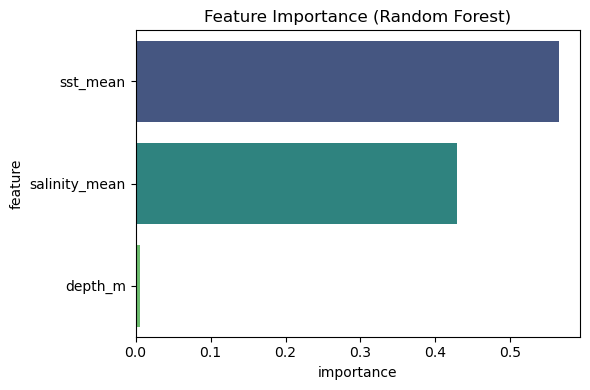

In [8]:
importances = rf.feature_importances_
fi_df = pd.DataFrame({"feature": features, "importance": importances}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.savefig("../figures/feature_importance_rf_final.png", dpi=300)
plt.show()


## 8️⃣ Predict Probability Grid Jepang


In [9]:
lat_grid = np.linspace(lat_min, lat_max, 200)
lon_grid = np.linspace(lon_min, lon_max, 200)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

grid_points = pd.DataFrame({
    "latitude": lat_mesh.ravel(),
    "longitude": lon_mesh.ravel()
})

grid_points["sst_mean"] = sample_biooracle(sst, grid_points["latitude"], grid_points["longitude"])
grid_points["salinity_mean"] = sample_biooracle(sal, grid_points["latitude"], grid_points["longitude"])
grid_points["depth_m"] = 10

# Clip ke range observasi
grid_points["sst_mean"] = np.clip(grid_points["sst_mean"], sst_min, sst_max)
grid_points["salinity_mean"] = np.clip(grid_points["salinity_mean"], sal_min, sal_max)

X_grid = grid_points[["sst_mean","salinity_mean","depth_m"]]
grid_points["prob_presence"] = rf.predict_proba(X_grid)[:,1]

prob_grid = grid_points["prob_presence"].values.reshape(lat_mesh.shape)

## 9️⃣ Plot Probability Map (Final)

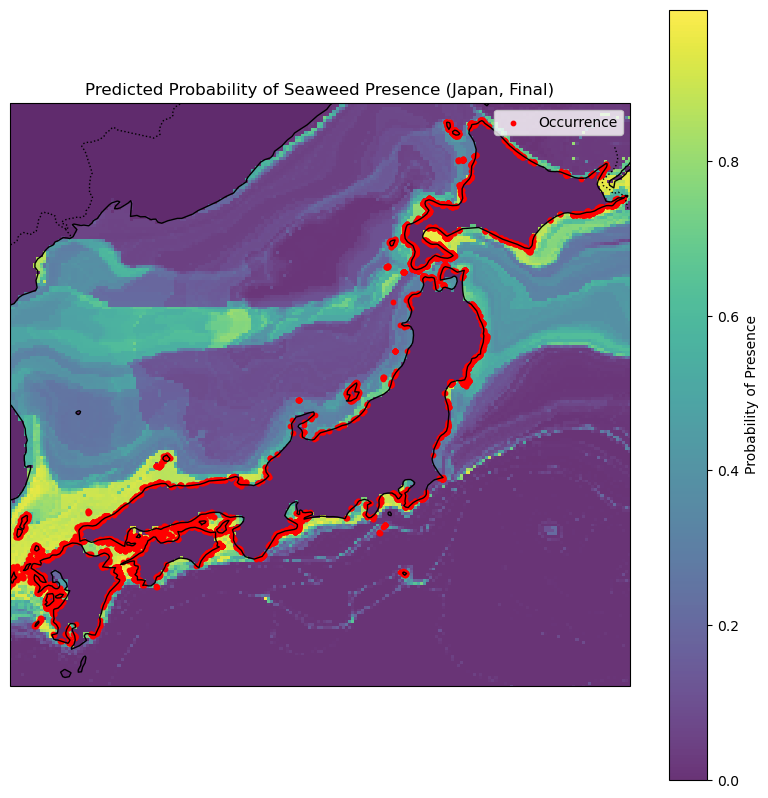

In [10]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

c = ax.pcolormesh(lon_mesh, lat_mesh, prob_grid, cmap='viridis', shading='auto', alpha=0.8)
plt.colorbar(c, ax=ax, orientation='vertical', label='Probability of Presence')

ax.scatter(df["decimalLongitude"], df["decimalLatitude"], color='red', s=10, label='Occurrence')
ax.legend()

plt.title("Predicted Probability of Seaweed Presence (Japan, Final)")
plt.savefig("../figures/probability_map_japan_final.png", dpi=300, bbox_inches='tight')
plt.show()


## 🔟 Save Predicted Grid


In [11]:
grid_points.to_csv("../data/processed/sdm_predicted_grid_japan_final.csv", index=False)
print("Grid probabilitas SDM disimpan: ../data/processed/sdm_predicted_grid_japan_final.csv")

Grid probabilitas SDM disimpan: ../data/processed/sdm_predicted_grid_japan_final.csv
